In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Reference - > https://neptune.ai/blog/arima-vs-prophet-vs-lstm

In [2]:
import sys
sys.path.insert(0, '../src/')
from models.stock_model import Stock
from api.lobster_api import stock_api
from api.technical_analysis import TechnicalAnalysis
from postgres_db import PostgresDB

In [3]:
stock_df = PostgresDB.query_to_df("select * from stock where symbol = 'AAPL'")
stock_symbols = stock_df['symbol'].to_list()

In [4]:
def quotes(stock_lst):
    df = pd.DataFrame()
    cols_of_interest = ['date', 'symbol', 'open', 'high', 'low', 'adjustedClose', 'volume']
    for index, stock_symbol in enumerate(stock_lst):
        print('Symbol - ', index, '. ',  stock_symbol)
        try:
            # Stock Quotes
            json = PostgresDB.query_to_df("select * from stock_historical_quote where symbol = '" + stock_symbol + "'" )['historical_quote'].iloc[0]
            temp_quote_df = pd.read_json(json)[cols_of_interest]
            temp_quote_df['date'] = temp_quote_df['date'].astype({'date': 'datetime64[ns]'})
            df = df.append(temp_quote_df[cols_of_interest])
        except Exception:
            print('Symbol ', stock_symbol, ' Errored.')
    return df

In [16]:
quotes_df = quotes(stock_symbols)
df = pd.DataFrame(data=quotes_df[['date', 'adjustedClose']])
df.rename(columns={'date': 'ds', 'adjustedClose': 'y'}, inplace=True)
df

Symbol -  0 .  AAPL


,ds,y
0,2022-12-20,132.300000
1,2022-12-19,132.370000
2,2022-12-16,134.510000
3,2022-12-15,136.500000
4,2022-12-14,143.210000
...,...,...
5818,1999-11-05,0.672034
5819,1999-11-04,0.636344
5820,1999-11-03,0.620210
5821,1999-11-02,0.610698


In [17]:
# Python
m = Prophet()
m.fit(df)

00:15:23 - cmdstanpy - INFO - Chain [1] start processing
00:15:27 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
future = m.make_future_dataframe(periods=365)
future.tail()


,ds
6183,2023-12-16
6184,2023-12-17
6185,2023-12-18
6186,2023-12-19
6187,2023-12-20


In [19]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
6183,2023-12-16,203.708707,195.421778,213.678619
6184,2023-12-17,203.873138,194.576535,213.837910
6185,2023-12-18,203.974471,194.058670,213.115353
6186,2023-12-19,204.173313,194.366240,212.852173
6187,2023-12-20,204.400553,195.264263,213.523225


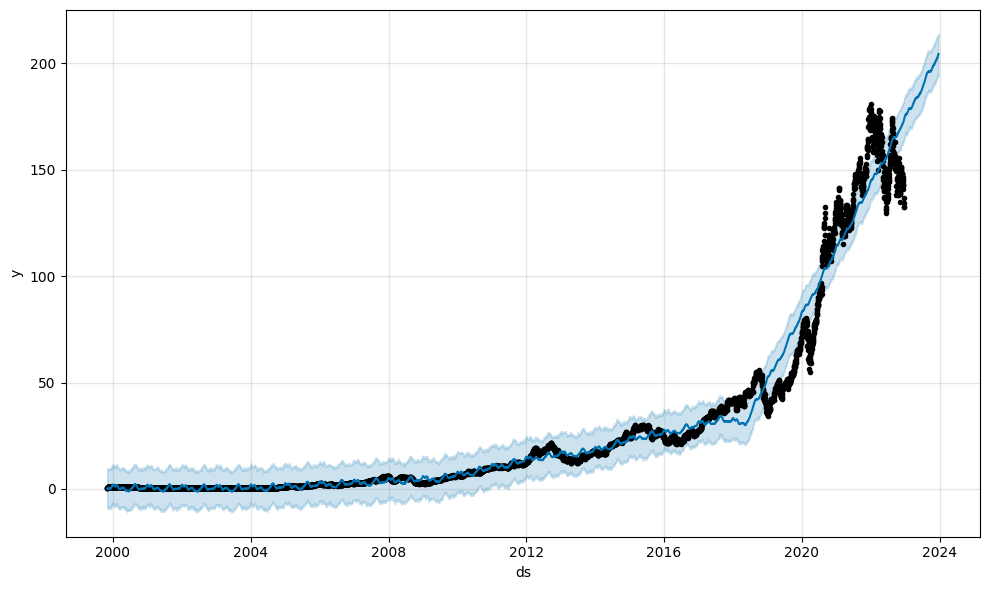

In [20]:
fig1 = m.plot(forecast)


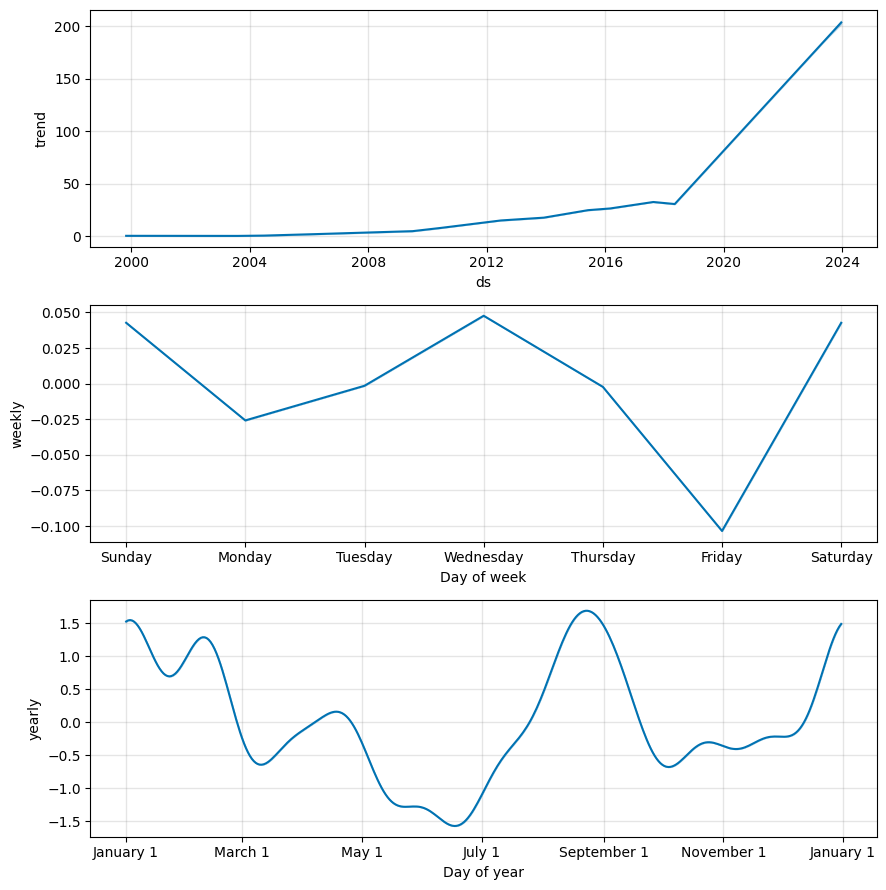

In [21]:
# Python
fig2 = m.plot_components(forecast)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=47acbe2e-cf49-4a5d-8910-b2139b3d8d7c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>